In [2]:
# using Pkg
# Pkg.add("RecipesBase")

# ENV["GRDIR"]=""
# Pkg.build("GR")
# using Conda
# Conda.add("Seaborn")
# Pkg.update()
# Pkg.add("https://github.com/tanhevg/GpABC.jl")

In [1]:
ENV["GKS_ENCODING"]="utf8"
using GpABC,OrdinaryDiffEq, Distances, Distributions, Plots, StatsBase, Printf, ODE, DifferentialEquations, Statistics, ModelingToolkit, CSV
using DelimitedFiles, StatsPlots, Dates, KernelDensity, PyCall, PyPlot, GR, RecipesBase,Conda
import Base.Iterators
@pyimport seaborn as sns
include("setup_ABC.jl") #imports the models and initial values
pyplot()

function log_euclidean(x,y)
    output = sqrt(sum((log10.(x.+0.00001) - log10.(y.+0.00001)) .^ 2))
    return (output/size(x)[1]) #average by the length of the vector
end

┌ Warning: `@pyimport foo` is deprecated in favor of `foo = pyimport("foo")`.
│   caller = _pywrap_pyimport(::PyObject) at PyCall.jl:399
└ @ PyCall C:\Users\leann\.julia\packages\PyCall\zqDXB\src\PyCall.jl:399


log_euclidean (generic function with 1 method)

In [166]:
#AA model using values of 50.0 (arbitriarily chosen) for all 6 parameters

global k_cat_AA = 50.
global k_a_NH4 = 50.
global k_NH4 = 50.
# global k_a_AA = 10.
# global k_NH4_AA = 10.
global k_x = 50.
global k_a = 50.

burn_in_prob_abc = ODEProblem(AA_simple, init, (0.,10000.0)) #set up the burn in problem
starting_NH4 = init[15]
# println("starting NH4 is $starting_NH4")
println("burning in model")
sol1_with_AA = solve(burn_in_prob_abc, saveat = 1.)
println("success")
step_num = size(sol1_with_AA,2)
final_state =sol1_with_AA[step_num]; #collect the end state after burning in to use as new initial values

final_state[1]= 1e12


# println("final state NH4 is $final_NH4")
println("run second stage model")
prob_abc = ODEProblem(AA_simple_with_popn_growth, final_state, (10000.0,20000.0)) #the problem to run ABC on using the burned in initial values
sol2_with_AA = solve(prob_abc, saveat = 1.0)
println("success")

burning in model
success
run second stage model
success


In [167]:
#burn in original model with extra equations removed

global k_cat_AA = 50.
global k_a_NH4 = 50.
global k_NH4 = 50.
# global k_a_AA = 10.
# global k_NH4_AA = 10.
global k_x = 50.
global k_a = 50.

burn_in_prob_abc = ODEProblem(original_model, init_original, (0.,10000.0)) #set up the burn in problem

println("burning in model")
sol1 = solve(burn_in_prob_abc, saveat = 1.)
println("success")
step_num = size(sol1,2)
final_state =sol1[step_num]; #collect the end state after burning in to use as new initial values
final_state[1]= 1e12


println("run second stage model")
prob_abc = ODEProblem(original_model_popn_growth_no_replenish, final_state, (10000.0,20000.0)) #the problem to run ABC on using the burned in initial values
sol2_original_model = solve(prob_abc, saveat = 1.)
println("success")


burning in model
success
run second stage model
success


In [170]:
popn_tracker_original = []
substrate_tracker_original = []
ATP_tracker_original = []
rmr_tracker_original=[]
for i in (1:10001)
    push!(popn_tracker_original,sol2_original_model.u[i][20])
    push!(substrate_tracker_original,sol2_original_model.u[i][1])
    push!(ATP_tracker_original,sol2_original_model.u[i][21])
    push!(rmr_tracker_original,sol2_original_model.u[i][2])

end

popn_tracker_with_AA = []
substrate_tracker_with_AA = []
ATP_tracker_with_AA = []
rmr_tracker_with_AA=[]
AA_tracker_with_AA=[]

for i in (1:10001)
    push!(popn_tracker_with_AA,sol2_with_AA.u[i][20])
    push!(substrate_tracker_with_AA,sol2_with_AA.u[i][1])
    push!(ATP_tracker_with_AA,sol2_with_AA.u[i][21])
    push!(rmr_tracker_with_AA,sol2_with_AA.u[i][2])
    push!(AA_tracker_with_AA,sol2_with_AA.u[i][22])
end

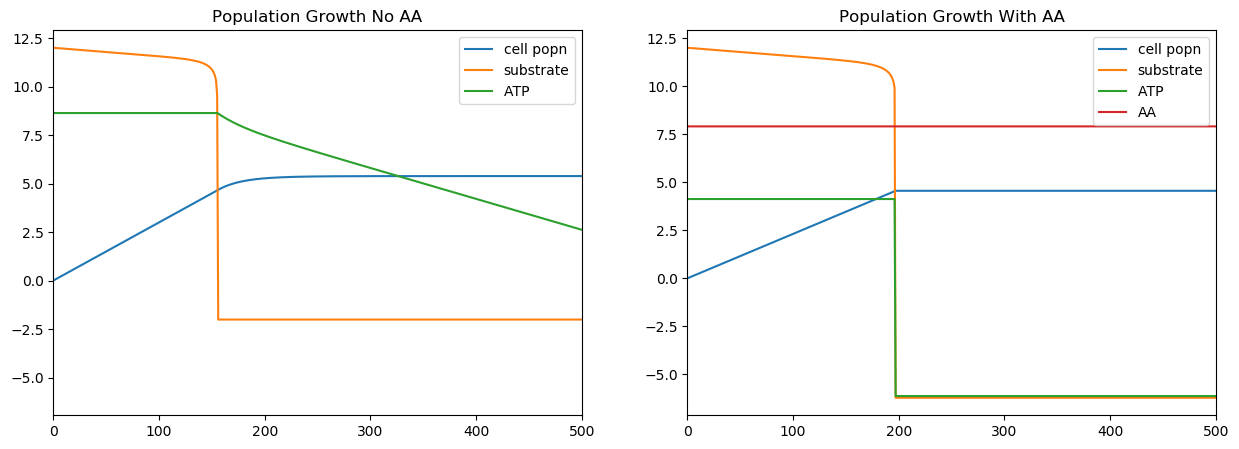

(0, 500)

In [172]:
fig, (ax1, ax2) =PyPlot.subplots(figsize=(15,5),ncols=2, nrows=1)
ax1.plot(log10.(popn_tracker_original),label = "cell popn")
ax1.plot(log10.(substrate_tracker_original),label = "substrate")
ax1.plot(log10.(ATP_tracker_original),label = "ATP")
# ax1.plot(log10.(rmr_tracker_original),label = "rmr")
ax1.legend()
ax1.set_title("Population Growth No AA")
ax1.set_xlim(0,500)

ax2.plot(log10.(popn_tracker_with_AA),label = "cell popn")
ax2.plot(log10.(substrate_tracker_with_AA),label = "substrate")
ax2.plot(log10.(ATP_tracker_with_AA),label = "ATP")
ax2.plot(log10.(AA_tracker_with_AA),label = "AA")
ax2.legend()
ax2.set_title("Population Growth With AA")
ax2.set_xlim(0,500)


In [37]:
# Plots.plot(log10.(popn_tracker_original), xlim = (100,300),label = "cell popn no AA",title = "log number of molecules per species",color = "red")
# Plots.plot!(log10.(substrate_tracker_original),label = "substrate no AA",color = "orange")
# Plots.plot!(log10.(ATP_tracker_original),label = "ATP no AA", colour = "yellow")

# Plots.plot(log10.(popn_tracker_with_AA),label = "cell popn with AA",colour = "blue", xlim = (230,235))
# Plots.plot!(log10.(substrate_tracker_with_AA),label = "substrate with AA", colour = "green")
# Plots.plot!(log10.(ATP_tracker_with_AA),label = "ATP with AA", colour = "purple", ylim = (-10,30))

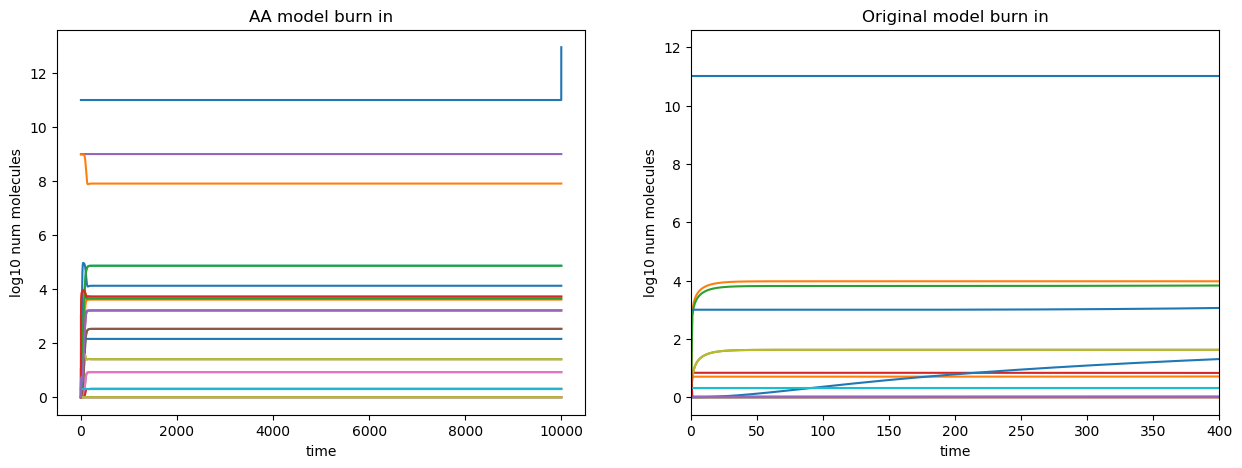

Figure(PyObject <Figure size 1500x500 with 2 Axes>)

In [7]:
fig, (ax1, ax2) =PyPlot.subplots(figsize=(15,5),ncols=2, nrows=1)
# subplot(21)
ax1.plot(log10.(sol1_with_AA'.+1),label = "")#, ax = ax[1,1])
ax1.set_title("AA model burn in")
ax1.axis("tight")
ax1.set_xlabel("time")
ax1.set_ylabel("log10 num molecules")

ax2.plot(log10.(sol1'.+1),label = "")
ax2.set_title("Original model burn in")
ax2.axis("tight")
ax2.set_xlabel("time")
ax2.set_ylabel("log10 num molecules")
ax2.set_xlim(0,400)

PyPlot.show(fig)

In [173]:
(popn_tracker_with_AA[100]-popn_tracker_with_AA[1])/100

0.019281832168230564

In [175]:
(popn_tracker_original[100]-popn_tracker_original[1])/100

9.307759793436368

In [ ]:
labels = ("substrate external", "ribo-bound mrna ribo", "enzyme metabolic", "ribo-bound mrna housekeeping", "ribo-bound mrna transporter","enzyme transporter", "ribo-bound mrna metabolic", "mrna transporter", "mrna metabolic", "housekeeping prot", "substrate internal", "housekeeping mrna", "ribo mrna", "free ribosomes", "internal NH4", "nitrogenase mrna","nitrogenase mrna ribo", "nitrogenase prot", "NH4 external", "Num cells", "ATP", "Amino Acids", "AA enzyme", "AA enzyme mrna", "ribo-bound AA enzyme mrna")
PyPlot.figure(figsize=(10,8))
PyPlot.barh(collect(1:25),(sol2_original_model[10001]'), log = "True", alpha = 0.5, label = "with AA", color = "red")
PyPlot.xlim(0,1e12)
PyPlot.barh(collect(1:25), (sol2_with_AA[10001]'),log = "True", alpha = 0.5, label = "no AA" , color = "blue")
# PyPlot.barh(collect(1:25),(sol2_original_model[10001]'), log = "True", alpha = 0.5, label = "original", color = "green")
PyPlot.yticks(collect(1:25), labels, rotation = "0")
PyPlot.xlabel("log number molecules")
PyPlot.legend()
PyPlot.title("Equilibrium values using 50.0 for all 5 params")
PyPlot.grid()
PyPlot.savefig("no_AA_with_AA_difference_plot.png")

In [43]:
#ribosome partitions
# rmr= y[2]#num of ribosome/ribosomal mRNA complex molecules
# rmq= y[4]#num of ribosome/housekeeping mRNA complex molecules
# rmt= y[5]#num of ribosome/transporter protein mRNA complex molecules
# rmm= y[7]#num of ribosome/metabolic enzyme mRNA complexes
# r= y[14]#num of free ribosomes
# nit_mrna_ribo = y[17]#num of molecules of mRNA coding for nitrogen fixing protein
# AA_mrna_ribo=y[25]#num of mRNA coding for AA making protein bound to ribosome

#proteome partitions
# em= y[3]#metabolic enzyme molecumes
# q= y[10]#num of housekeeping protein molecules
# et= y[6]#num of transporter enzyme molecules
# r= y[14]#num of free ribosomes
# nit = y[18]#num of molecules of mRNA-ribosome complexes coding for nitrogenase
# AA_prot=y[23]#num of protein molecules that make new amino acids

In [148]:
ribo_breakdown_AA=[sol2_with_AA.u[10001][2],sol2_with_AA.u[10001][5],sol2_with_AA.u[10001][4],sol2_with_AA[10001][7],sol2_with_AA.u[10001][14],sol2_with_AA.u[10001][25]]
ribo_breakdown_no_AA=[sol2_original_model.u[10001][2],sol2_original_model.u[10001][5],sol2_original_model.u[10001][4],sol2_original_model[10001][7],sol2_original_model.u[10001][14]]#,sol2_original_model.u[10001][17],sol2_original_model.u[10001][25]]

5-element Array{Float64,1}:
  152.8588545108589  
   28.94363867824317 
 5080.226934940702   
   28.943638677940257
 3408.729631054424   

In [142]:
total_ribo_AA=sol2_with_AA.u[10001][2]+sol2_with_AA.u[10001][5]+sol2_with_AA.u[10001][4]+sol2_with_AA[10001][7]+sol2_with_AA.u[10001][25]+sol2_with_AA.u[10001][14]
percent_rmr_AA = round(sol2_with_AA.u[10001][2]/total_ribo_AA*100, digits=1)
percent_rmt_AA = round(sol2_with_AA.u[10001][5]/total_ribo_AA*100, digits=1)
percent_rmq_AA = round(sol2_with_AA.u[10001][4]/total_ribo_AA*100, digits=1)
percent_rmm_AA= round(sol2_with_AA.u[10001][7]/total_ribo_AA*100, digits=1)
percent_free_AA= round(sol2_with_AA.u[10001][14]/total_ribo_AA*100, digits=1)
percent_nit_mrna_ribo=round(sol2_with_AA.u[10001][17]/total_ribo_AA*100, digits=1)
percent_bound_AA_AA= round(sol2_with_AA.u[10001][25]/total_ribo_AA*100, digits=1)

17.5

In [126]:
total_ribo_no_AA

8699.702697862169

In [136]:
total_ribo_no_AA=sol2_original_model.u[10001][2]+sol2_original_model.u[10001][5]+sol2_original_model.u[10001][4]+sol2_original_model[10001][7]+sol2_original_model.u[10001][14]
percent_rmr_no_AA = round(sol2_original_model.u[10001][2]/total_ribo_no_AA*100, digits=1)
percent_rmt_no_AA = round(sol2_original_model.u[10001][5]/total_ribo_no_AA*100, digits=1)
percent_rmq_no_AA = round(sol2_original_model.u[10001][4]/total_ribo_no_AA*100, digits=1)
percent_rmm_no_AA= round(sol2_original_model.u[10001][7]/total_ribo_no_AA*100, digits=1)
percent_free_no_AA= round(sol2_original_model.u[10001][14]/total_ribo_no_AA*100, digits=1)
percent_nit_mrna_ribo_no=round(sol2_original_model.u[10001][17]/total_ribo_no_AA*100, digits=1)
percent_bound_no_AA_AA= round(sol2_original_model.u[10001][25]/total_ribo_no_AA*100, digits=1)

0.0

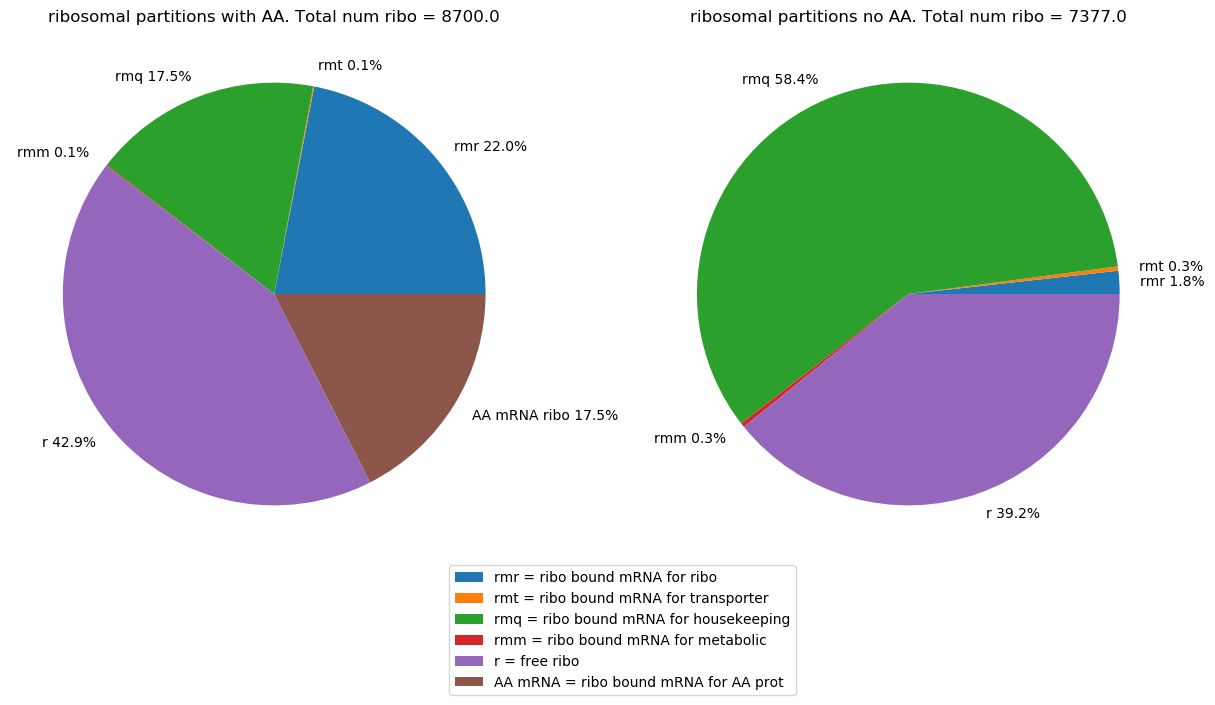

PyObject Text(0.5, 1, 'ribosomal partitions no AA. Total num ribo = 7377.0')

In [147]:
# percent_bound_AA = round(ribo_breakdown_AA[1]/(ribo_breakdown_AA[2]+ribo_breakdown_AA[1]+ribo_breakdown_AA[3])*100)
# percent_free_AA=round(ribo_breakdown_AA[4]/(ribo_breakdown_AA[2]+ribo_breakdown_AA[1]+ribo_breakdown_AA[3] )*100)
# percent_bound_AA_AA=round(ribo_breakdown_AA[3]/(ribo_breakdown_AA[2]+ribo_breakdown_AA[1]+ribo_breakdown_AA[3])*100)
# percent_bound_AA_AA=round(ribo_breakdown_AA[2]/(ribo_breakdown_AA[2]+ribo_breakdown_AA[1]+ribo_breakdown_AA[3])*100)

# percent_bound_no_AA= round(ribo_breakdown_no_AA[1]/(ribo_breakdown_no_AA[2]+ribo_breakdown_no_AA[1]+ribo_breakdown_no_AA[3])*100)
# percent_free_no_AA= round(ribo_breakdown_no_AA[3]/(ribo_breakdown_no_AA[2]+ribo_breakdown_no_AA[1]+ribo_breakdown_no_AA[3])*100)
# precent_bound_no_AA_AA=round(ribo_breakdown_no_AA[2]/(ribo_breakdown_no_AA[2]+ribo_breakdown_no_AA[1]+ribo_breakdown_no_AA[3])*100)

fig, (ax1, ax2) =PyPlot.subplots(figsize=(15,8),ncols=2, nrows=1)

wedges,texts =ax1.pie(ribo_breakdown_AA#, wedgeprops=dict(width=0.5), startangle=-40)
, labels = ("rmr $percent_rmr_AA%", "rmt $percent_rmt_AA%","rmq $percent_rmq_AA%", "rmm $percent_rmm_AA%", "r $percent_free_AA%" , "AA mRNA ribo $percent_bound_AA_AA%"))
rounded_ribo_no_AA= round(total_ribo_no_AA)
ax1.set_title("ribosomal partitions with AA. Total num ribo = $rounded_ribo_no_AA")
ax1.legend(["rmr = ribo bound mRNA for ribo","rmt = ribo bound mRNA for transporter", "rmq = ribo bound mRNA for housekeeping","rmm = ribo bound mRNA for metabolic","r = free ribo","AA mRNA = ribo bound mRNA for AA prot"],
          bbox_to_anchor=(1, -1, 0.5, 1))


ax2.pie(ribo_breakdown_no_AA, labels = ("rmr $percent_rmr_no_AA%", "rmt $percent_rmt_no_AA%","rmq $percent_rmq_no_AA%", "rmm $percent_rmm_no_AA%", "r $percent_free_no_AA%" ))#, "AA mRNA $percent_bound_no_AA_AA%"))
rounded_ribo_with_AA = round(total_ribo_AA)
ax2.set_title("ribosomal partitions no AA. Total num ribo = $rounded_ribo_with_AA")
# ax2.legend(["rmr = ribo bound mRNA for ribo", "rmq = ribo bound mRNA for housekeeping","rmt = ribo bound mRNA for transporter","rmm = ribo bound mRNA for metabolic","r = free ribo","nit mrna ribo = ribo bound mRNA for nitrogenase","AA mRNA = ribo bound mRNA for AA prot"],
#           bbox_to_anchor=(0.3, -1, 0.5, 1))


In [163]:
#proteome partitions
# em= y[3]#metabolic enzyme molecumes
# et= y[6]#num of transporter enzyme molecules
# q= y[10]#num of housekeeping protein molecules
# r=  total_ribo_no_AA /total_ribo_AA y[14]#num of free ribosomes
# nit = y[18]#num of molecules of mRNA-ribosome complexes coding for nitrogenase
# AA_prot=y[23]#num of protein molecules that make new amino acids



proteome_with_AA = [sol2_with_AA.u[10001][3],sol2_with_AA.u[10001][10],sol2_with_AA.u[10001][6],total_ribo_AA,sol2_with_AA.u[10001][23]]
proteome_no_AA = [sol2_original_model.u[10001][3],sol2_original_model.u[10001][10],sol2_original_model.u[10001][6],total_ribo_no_AA,sol2_original_model.u[10001][23]]


total_proteome_with_AA=sol2_with_AA.u[10001][3]+sol2_with_AA.u[10001][6]+sol2_with_AA.u[10001][10]+total_ribo_AA+sol2_with_AA.u[10001][23]
percent_em_with_AA = round(sol2_with_AA.u[10001][3]/total_proteome_with_AA*100, digits=1)
percent_et_with_AA = round(sol2_with_AA.u[10001][6]/total_proteome_with_AA*100, digits=1)
percent_q_with_AA = round(sol2_with_AA.u[10001][10]/total_proteome_with_AA*100, digits=1)
percent_r_with_AA = round(sol2_with_AA.u[10001][14]/total_proteome_with_AA*100, digits=1)
# percent_nit_with_AA = round(sol2_with_AA.u[10001][18]/total_proteome_with_AA*100, digits=1)
percent_AA_prot_with_AA = round(sol2_with_AA.u[10001][23]/total_proteome_with_AA*100, digits=1)

total_proteome_no_AA=sol2_original_model.u[10001][3]+sol2_original_model.u[10001][6]+sol2_original_model.u[10001][10]+total_ribo_no_AA+sol2_original_model.u[10001][23]
percent_em_no_AA = round(sol2_original_model.u[10001][3]/total_proteome_no_AA*100, digits=1)
percent_et_no_AA = round(sol2_original_model.u[10001][6]/total_proteome_no_AA*100, digits=1)
percent_q_no_AA = round(sol2_original_model.u[10001][10]/total_proteome_no_AA*100, digits=1)
percent_r_no_AA = round(sol2_original_model.u[10001][14]/total_proteome_no_AA*100, digits=1)
# percent_nit_no_AA = round(sol2_original_model.u[10001][18]/total_proteome_no_AA*100, digits=1)
percent_AA_prot_no_AA = round(sol2_original_model.u[10001][23]/total_proteome_no_AA*100, digits=1)

0.0

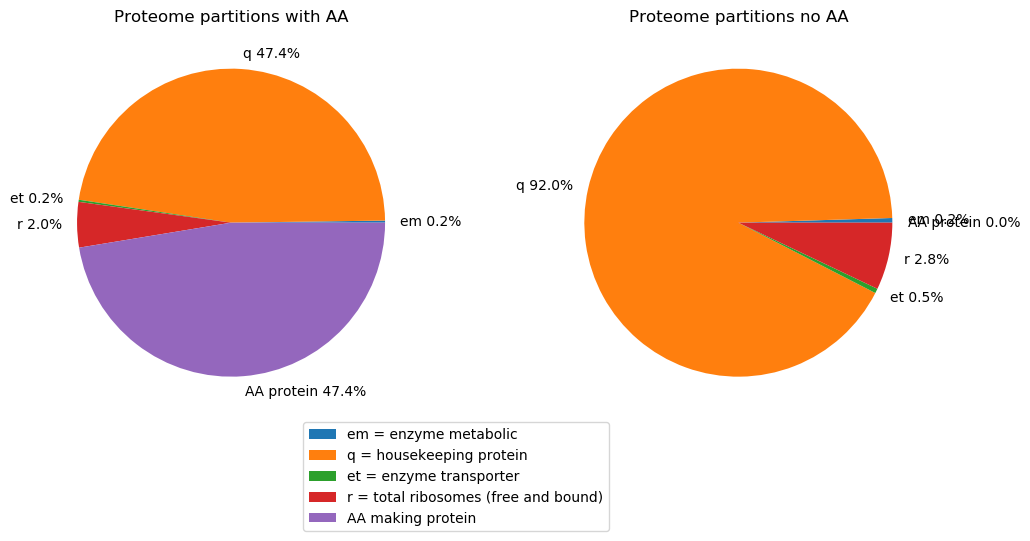

PyObject <matplotlib.legend.Legend object at 0x00000000E6D7C278>

In [165]:
fig, (ax1, ax2) =PyPlot.subplots(figsize=(12,5),ncols=2, nrows=1)

ax1.pie(proteome_with_AA, labels = ("em $percent_em_with_AA%", "q $percent_q_with_AA%","et $percent_et_with_AA%", "r $percent_r_with_AA%", "AA protein $percent_AA_prot_with_AA%"))
ax1.set_title("Proteome partitions with AA")

ax2.pie(proteome_no_AA, labels = ("em $percent_em_with_AA%", "q $percent_q_no_AA%","et $percent_et_no_AA%", "r $percent_r_no_AA%", "AA protein $percent_AA_prot_no_AA%"))
ax2.set_title("Proteome partitions no AA")

ax1.legend(["em = enzyme metabolic","q = housekeeping protein", "et = enzyme transporter","r = total ribosomes (free and bound)","AA making protein"],
          bbox_to_anchor=(1, -1, 0.5, 1))

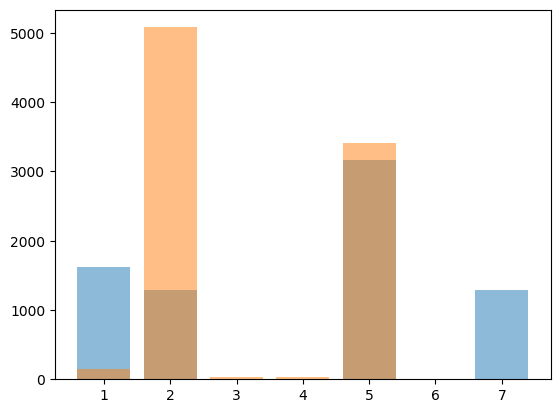

(PyObject <matplotlib.patches.Rectangle object at 0x000000006B611DA0>, PyObject <matplotlib.patches.Rectangle object at 0x000000006B62D668>, PyObject <matplotlib.patches.Rectangle object at 0x000000006CB562E8>, PyObject <matplotlib.patches.Rectangle object at 0x000000006CB565F8>, PyObject <matplotlib.patches.Rectangle object at 0x000000006CB56908>, PyObject <matplotlib.patches.Rectangle object at 0x000000006CB56C18>, PyObject <matplotlib.patches.Rectangle object at 0x000000006CB56F28>)

In [29]:
PyPlot.bar(collect(1:7),ribo_breakdown_AA, alpha = 0.5)
PyPlot.bar(collect(1:7),ribo_breakdown_no_AA, alpha = 0.5)

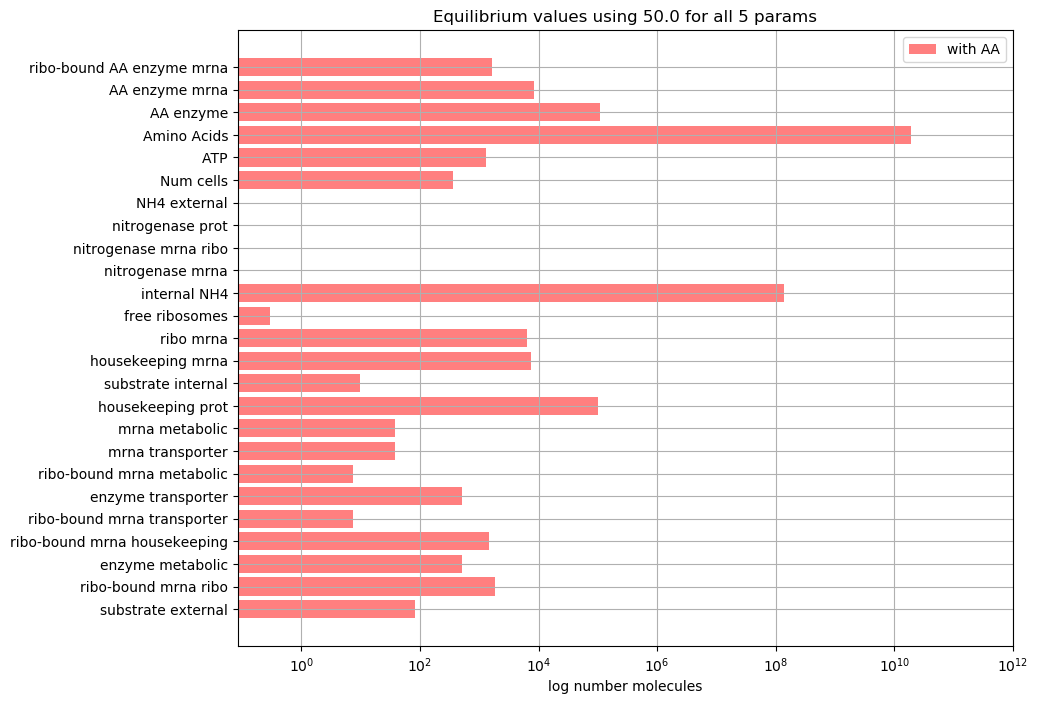

In [56]:
labels = ("substrate external", "ribo-bound mrna ribo", "enzyme metabolic", "ribo-bound mrna housekeeping", "ribo-bound mrna transporter","enzyme transporter", "ribo-bound mrna metabolic", "mrna transporter", "mrna metabolic", "housekeeping prot", "substrate internal", "housekeeping mrna", "ribo mrna", "free ribosomes", "internal NH4", "nitrogenase mrna","nitrogenase mrna ribo", "nitrogenase prot", "NH4 external", "Num cells", "ATP", "Amino Acids", "AA enzyme", "AA enzyme mrna", "ribo-bound AA enzyme mrna")
PyPlot.figure(figsize=(10,8))
PyPlot.barh(collect(1:25),(sol2_with_AA[10001]'), log = "True", alpha = 0.5, label = "with AA", color = "red")
PyPlot.xlim(0,1e12)
# PyPlot.barh(collect(1:25), (sol2_no_AA[10001]'),log = "True", alpha = 0.5, label = "no AA" , color = "blue")
# PyPlot.barh(collect(1:25),(sol2_original_model[10001]'), log = "True", alpha = 0.5, label = "original", color = "green")
PyPlot.yticks(collect(1:25), labels, rotation = "0")
PyPlot.xlabel("log number molecules")
PyPlot.legend()
PyPlot.title("Equilibrium values using 50.0 for all 5 params")
PyPlot.grid()
PyPlot.savefig("no_AA_with_AA_difference_plot.png")

In [44]:
print((sol2_with_AA[10001]'-sol2_original_model[10001]')./sol2_with_AA[10001]'.*100)

[0.0 -58.3944075936877 -49.77071129301911 -68.91499058751478 -88.48008425315903 -49.77071129301839 -88.48008425315994 23.32838041939836 23.328380419398055 -34.22382735337492 -0.00046919767684123424 31.287244744693655 36.232374946519016 -152.5022407828511 100.0 NaN NaN NaN NaN 0.0 -3.2368987160393926e6 100.0 100.0 100.0 100.0]

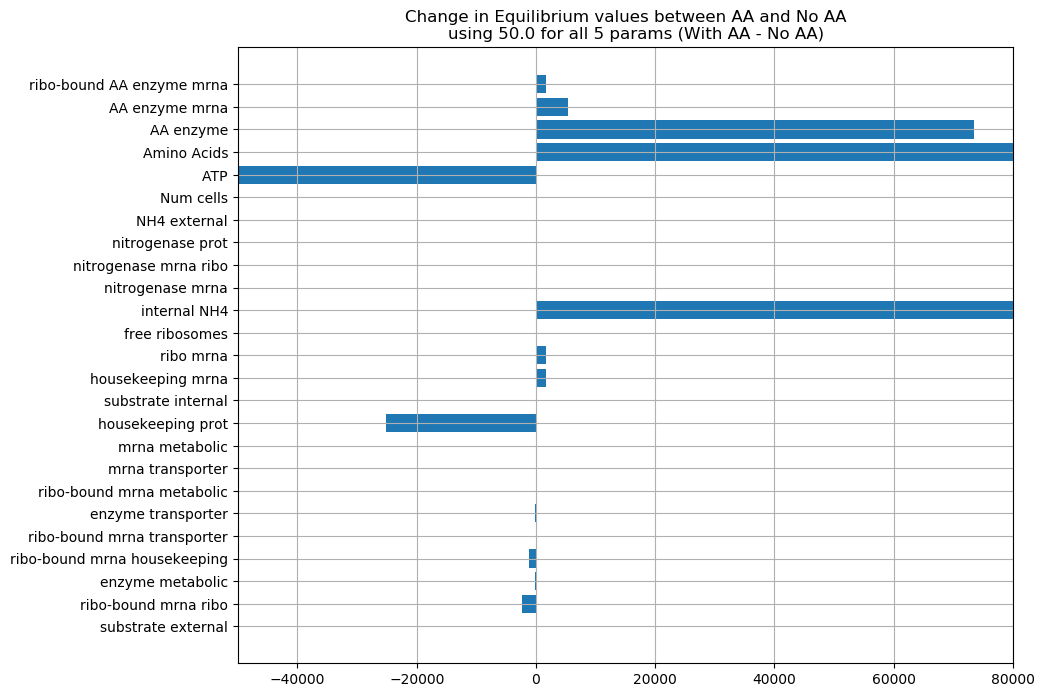

In [24]:
PyPlot.figure(figsize=(10,8))
# PyPlot.barh(collect(1:25),(sol2_no_AA[10001]'-sol2_with_AA[10001]'), log = "True", alpha = 0.5, label = "with AA", color = "red")
PyPlot.yticks(collect(1:25), labels, rotation = "0")
PyPlot.title("Change in Equilibrium values between AA and No AA
    using 50.0 for all 5 params (With AA - No AA)")
PyPlot.xlim((-5e4,8e4))
PyPlot.barh(collect(1:25),(sol2_with_AA[10001]'-sol2_no_AA[10001]'))
PyPlot.grid()
PyPlot.savefig("subtracted_difference_with_AA-no_AA.png")

In [169]:
"""Simulator function that runs the burned in simple Amino Acid model to be used in GP ABC SMC.
Default of 10,000 timesteps. Has up to 6 parameter inputs."""
function simulator_function_lm(params, time1= 10000.0)
    global k_cat_AA = params[1]
    global k_a_NH4 = params[2] #this paramter cannot equal zero
    global k_NH4 = params[3]
#     global k_a_AA = params[4]
#     global k_NH4_AA = params[5]
    global k_x = params[4]
    global k_a = params[5]
    
    prob = ODEProblem(AA_simple, final_state,(0., time1),params)
    sol = solve(prob, Rodas4(),saveat = 1.)
    return Array{Float64, 2}(sol)
end

simulator_function_lm

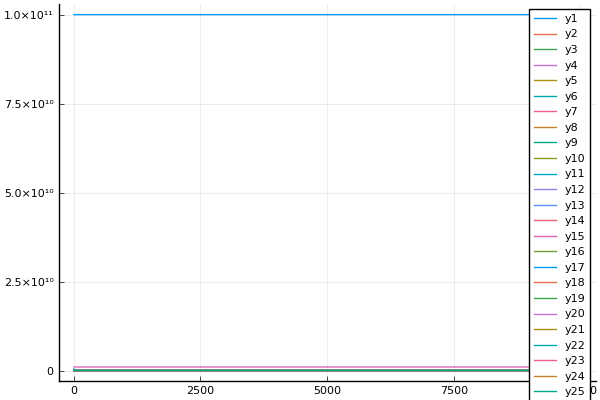

In [7]:
test_params = [50.0,50.0,50.0,50.0,50.0]
Plots.plot(simulator_function_lm(test_params)')

In [8]:
population_colors=["#FF2F4E", "#D0001F", "#A20018", "#990017", "#800013"]
threshold_schedule = [0.005,0.001, 0.0007, 0.0005, 0.0001,0.00005];
n_particles = 500

real_param_vect1 = []
real_param_vect2 = []
real_param_vect3= []
final_popns1 = []
final_popns2 = []
final_popns3 = []
difference_vect = []

0-element Array{Any,1}

In [1]:
threshold_schedule =[
0.00000200,
0.00000100,
0.00000050,
0.00000025,
0.00000012,
0.00000006,
0.00000003,
0.00000001];

#length 5

In [17]:
# println("real params are $params_lm")
# println("priors are $priors")
# println("n_particles is $n_particles")

# sim_abc_res = SimulatedABCSMC(results,
#     simulator_function_lm,
#     priors,
#     [0.0005],
#     1000,
#     distance_function = log_euclidean,
#     write_progress=true)

In [93]:
params_lm

5-element Array{Float64,1}:
 56.06884488069524
 77.65480446372273
 88.31957401676975
 79.20359329854531
 57.21915973145046

In [ ]:
# params_lm = rand(5)*200 #pick values for the parameters randomly from a uniform distribution between 0 and 20
# results = simulator_function_lm(params_lm);
# abc_smc_results = []
# population_tracker = []

priors = [Uniform(0.1, 200.0), Uniform(0.1,200.0), Uniform(0.1, 200.0),Uniform(0.1, 200.), Uniform(0.1, 200.)]

println("real params are $params_lm")
# println("priors are $priors")
# println("n_particles is $n_particles")

sim_results = SimulatedABCSMC(results,
    simulator_function_lm,
    priors,
    threshold_schedule,
#     [1.0],
#     n_particles,
    500,#num particles
    distance_function = log_euclidean,
    write_progress=true,
    max_iter=convert(Int, 120000))


real params are [56.06884488069524, 77.65480446372273, 88.31957401676975, 79.20359329854531, 57.21915973145046]


┌ Info: GpABC rejection simulation. ϵ = 2.0e-6.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\e09ZY\src\abc\rejection.jl:47
┌ Info: GpABC rejection simulation. Accepted 4/1000 particles.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\e09ZY\src\abc\rejection.jl:87
┌ Info: GpABC rejection simulation. Accepted 10/2000 particles.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\e09ZY\src\abc\rejection.jl:87
┌ Info: GpABC rejection simulation. Accepted 16/3000 particles.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\e09ZY\src\abc\rejection.jl:87
┌ Info: GpABC rejection simulation. Accepted 25/4000 particles.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\e09ZY\src\abc\rejection.jl:87
┌ Info: GpABC rejection simulation. Accepted 34/5000 particles.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\e09ZY\src\abc\rejection.jl:87
┌ Info: GpABC rejection simulation. Accepted 44/6000 particles.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\e09ZY\src\abc\rejection.jl:87
┌ Info: GpABC rejection simula

In [ ]:
println(quantile(sim_results.distances[1],0.01))
println(quantile(sim_results.distances[1],0.99))
Plots.histogram(sim_results.distances)
# temp_results.distances[1]

In [ ]:
Plots.plot(temp_results)

In [51]:
size(sim_results.population[3])

(184, 6)

In [ ]:
Plots.histogram(sim_results.population[1][:,1], bins = 10)
Plots.histogram!(sim_results.population[11][:,1], bins = 10)

In [41]:
params_lm

5-element Array{Float64,1}:
 16.356575687413454 
  7.769493725970635 
 14.760461128600845 
  4.3862048859155545
 10.093048071918416 

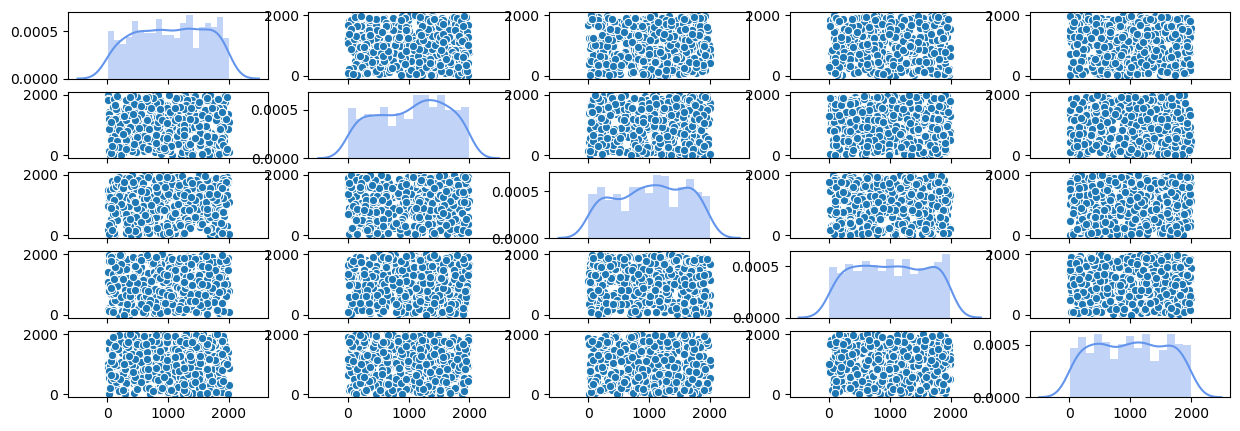

Figure(PyObject <Figure size 1500x500 with 25 Axes>)

In [69]:
#plotting recipe from GpABC paper, maybe useful?

data = sim_results
pop_num = 1
fig, ax = PyPlot.subplots(figsize=(15,5),ncols=5, nrows=5, sharex = "all")
# sns.lineplot(x=[params_lm[1], params_lm[1]],y=[0,20], ax = ax[1,1], color = "red")
sns.distplot(data.population[pop_num][:,1] ,bins=20, kde= true, hist=true,rug= false ,color = "cornflowerblue",ax=ax[1,1])
sns.distplot(data.population[pop_num][:,2],bins=15, kde= true, hist=true,rug= false , color = "cornflowerblue", ax=ax[2,2])
sns.distplot(data.population[pop_num][:,3],bins=15, kde= true, hist=true,rug= false ,  color = "cornflowerblue", ax=ax[3,3])
sns.distplot(data.population[pop_num][:,4],bins=15, kde= true, hist=true,rug= false ,  color = "cornflowerblue", ax=ax[4,4])
sns.distplot(data.population[pop_num][:,5],bins=15, kde= true, hist=true,rug= false ,  color = "cornflowerblue", ax=ax[5,5])
# sns.distplot(data.population[pop_num][:,6],bins=15, kde= true, hist=true,rug= false ,  color = "cornflowerblue", ax=ax[6,6])

sns.scatterplot(data.population[pop_num][:,1],data.population[pop_num][:,2], ax = ax[2,1]) 
sns.scatterplot(data.population[pop_num][:,1],data.population[pop_num][:,3], ax = ax[3,1]) 
sns.scatterplot(data.population[pop_num][:,1],data.population[pop_num][:,4], ax = ax[4,1]) 
sns.scatterplot(data.population[pop_num][:,1],data.population[pop_num][:,5], ax = ax[5,1]) 
# sns.scatterplot(data.population[pop_num][:,1],data.population[pop_num][:,6], ax = ax[6,1]) 

sns.scatterplot(data.population[pop_num][:,2],data.population[pop_num][:,1], ax = ax[1,2]) 
sns.scatterplot(data.population[pop_num][:,3],data.population[pop_num][:,1], ax = ax[1,3])
sns.scatterplot(data.population[pop_num][:,4],data.population[pop_num][:,1], ax = ax[1,4]) 
sns.scatterplot(data.population[pop_num][:,5],data.population[pop_num][:,1], ax = ax[1,5]) 
# sns.scatterplot(data.population[pop_num][:,6],data.population[pop_num][:,1], ax = ax[1,6]) 

sns.scatterplot(data.population[pop_num][:,2],data.population[pop_num][:,3], ax = ax[3,2]) 
sns.scatterplot(data.population[pop_num][:,2],data.population[pop_num][:,4], ax = ax[4,2]) 
sns.scatterplot(data.population[pop_num][:,2],data.population[pop_num][:,5], ax = ax[5,2]) 
# sns.scatterplot(data.population[pop_num][:,2],data.population[pop_num][:,6], ax = ax[6,2])

sns.scatterplot(data.population[pop_num][:,3],data.population[pop_num][:,2], ax = ax[2,3]) 
sns.scatterplot(data.population[pop_num][:,4],data.population[pop_num][:,2], ax = ax[2,4]) 
sns.scatterplot(data.population[pop_num][:,5],data.population[pop_num][:,2], ax = ax[2,5]) 
# sns.scatterplot(data.population[pop_num][:,6],data.population[pop_num][:,2], ax = ax[2,6])

sns.scatterplot(data.population[pop_num][:,3],data.population[pop_num][:,4], ax = ax[4,3]) 
sns.scatterplot(data.population[pop_num][:,3],data.population[pop_num][:,5], ax = ax[5,3]) 
# sns.scatterplot(data.population[pop_num][:,3],data.population[pop_num][:,6], ax = ax[6,3])

sns.scatterplot(data.population[pop_num][:,4],data.population[pop_num][:,3], ax = ax[3,4]) 
sns.scatterplot(data.population[pop_num][:,5],data.population[pop_num][:,3], ax = ax[3,5]) 
# sns.scatterplot(data.population[pop_num][:,6],data.population[pop_num][:,3], ax = ax[3,6])


sns.scatterplot(data.population[pop_num][:,4],data.population[pop_num][:,5], ax = ax[5,4]) 
# sns.scatterplot(data.population[pop_num][:,4],data.population[pop_num][:,6], ax = ax[6,4])

sns.scatterplot(data.population[pop_num][:,5],data.population[pop_num][:,4], ax = ax[4,5]) 
# sns.scatterplot(data.population[pop_num][:,6],data.population[pop_num][:,4], ax = ax[4,6])

# sns.scatterplot(data.population[pop_num][:,5],data.population[pop_num][:,6], ax = ax[6,5])

# sns.scatterplot(data.population[pop_num][:,6],data.population[pop_num][:,5], ax = ax[5,6])

#  sns.jointplot(y="param_1", x="param_2", data=sim_plot_data, kind="kde", color="cornflowerblue", ax=ax[1,2])
#  sns.jointplot(y="param_1", x="param_3", data=sim_plot_data, kind="kde", color="cornflowerblue",ax=ax[1,3])
#  sns.jointplot(y="param_2", x="param_1", data=sim_plot_data, kind="kde", color="cornflowerblue",ax=ax[2,3])
# PyPlot.savefig(fname="5_param_popn_4.png")
PyPlot.show(fig)

In [53]:
params_lm

5-element Array{Float64,1}:
 16.356575687413454 
  7.769493725970635 
 14.760461128600845 
  4.3862048859155545
 10.093048071918416 

In [108]:
?PyPlot.subplots


    Create a figure and a set of subplots.

    This utility wrapper makes it convenient to create common layouts of
    subplots, including the enclosing figure object, in a single call.

    Parameters
    ----------
    nrows, ncols : int, optional, default: 1
        Number of rows/columns of the subplot grid.

    sharex, sharey : bool or {'none', 'all', 'row', 'col'}, default: False
        Controls sharing of properties among x (`sharex`) or y (`sharey`)
        axes:

            - True or 'all': x- or y-axis will be shared among all
              subplots.
            - False or 'none': each subplot x- or y-axis will be
              independent.
            - 'row': each subplot row will share an x- or y-axis.
            - 'col': each subplot column will share an x- or y-axis.

        When subplots have a shared x-axis along a column, only the x tick
        labels of the bottom subplot are created. Similarly, when subplots
        have a shared y-axis along a row, only th

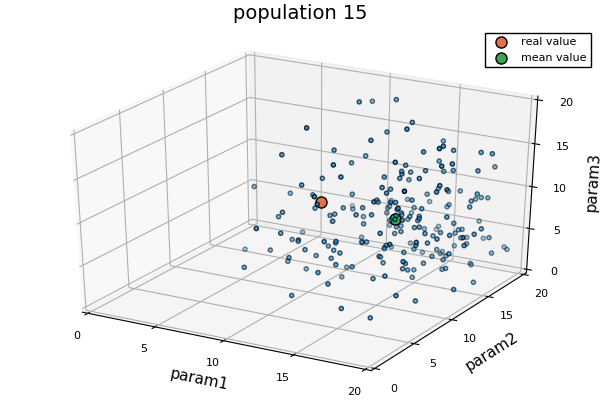

In [119]:
pyplot()
pop_num = 15 #change this to look at the various SMC populations
xc = sim_abc_res.population[pop_num][:,1]
yc = sim_abc_res.population[pop_num][:,2]
zc = sim_abc_res.population[pop_num][:,3]
scatter3d(xc,yc,zc, xlab = "param1", ylab = "param2", zlab = "param3", label = "",camera=(30,30), markersize = 3, title = "population $pop_num",ylim = (0,20),xlim = (0,20), zlim = (0,20))#,st=:surface)
scatter3d!([(12.3, 7.6, 12.2)], label = "real value", markersize = 8)
scatter3d!([(mean(sim_abc_res.population[pop_num][:,1]),mean(sim_abc_res.population[pop_num][:,2]),mean(sim_abc_res.population[pop_num][:,3]))], markersize = 8, label = "mean value")

# Plots.savefig("../images/abc_smc_output/popn_$pop_num.png")

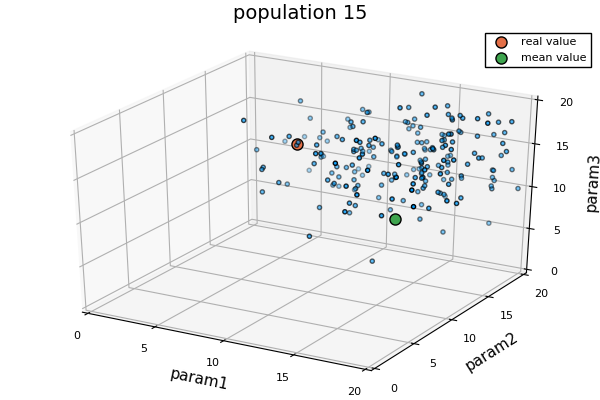

In [105]:
pyplot()
pop_num = 15 #change this to look at the various SMC populations
xc = sim_abc_res.population[pop_num][:,4]
yc = sim_abc_res.population[pop_num][:,5]
zc = sim_abc_res.population[pop_num][:,6]
scatter3d(xc,yc,zc, xlab = "param1", ylab = "param2", zlab = "param3", label = "",camera=(30,30), markersize = 3, title = "population $pop_num",ylim = (0,20),xlim = (0,20), zlim = (0,20))#,st=:surface)
scatter3d!([(9.0, 10.34, 16.6)], label = "real value", markersize = 8)
scatter3d!([(mean(sim_abc_res.population[pop_num][:,1]),mean(sim_abc_res.population[pop_num][:,2]),mean(sim_abc_res.population[pop_num][:,3]))], markersize = 8, label = "mean value")

# Plots.savefig("../images/abc_smc_output/popn_$pop_num.png")

In [108]:
println("real params are $params_lm")
end_pop = size(sim_abc_res.population)[1]
print("estm params are ",mean(sim_abc_res.population[end_pop][:,1]), " ")
print(mean(sim_abc_res.population[end_pop][:,2]), " ")
print(mean(sim_abc_res.population[end_pop][:,3]), " ")
print(mean(sim_abc_res.population[end_pop][:,4]), " ")
print(mean(sim_abc_res.population[end_pop][:,5]), " ")
println(mean(sim_abc_res.population[end_pop][:,6]))

real_ratio = params_lm[1]/params_lm[2]
println("real ratio is $real_ratio")
estim_ratio= (mean(sim_abc_res.population[end_pop][:,1]))/(mean(sim_abc_res.population[end_pop][:,2]))
println("estim ratio is $estim_ratio")
# plot(abc_smc_results[1], size = (900,700))
# plot!(abc_smc_results[4])
# plot!(abc_smc_results[7])
# plot!(abc_smc_results[10])
# # plot!(abc_smc_results[5])

real params are [12.316521242215277, 7.604193708168703, 12.275929241989147, 11.640735036540475, 9.926847911788226, 17.001343439399072]
estm params are 14.479394603181454 13.222492803447809 8.055257412167691 13.433366125979974 15.500736922161332 13.58848264771807
real ratio is 1.6197011431973938
estim ratio is 1.0950578547039107


In [68]:
# end_pop = size(sim_abc_res.population)[1]
end_pop = 11
println("num of popns is $end_pop")
est_param = []
println("real params are    ",params_lm)
push!(est_param,mean(sim_abc_res.population[end_pop][:,1]))
push!(est_param,mean(sim_abc_res.population[end_pop][:,2]))
push!(est_param,mean(sim_abc_res.population[end_pop][:,3]))
push!(est_param,mean(sim_abc_res.population[end_pop][:,4]))
push!(est_param,mean(sim_abc_res.population[end_pop][:,5]))
push!(est_param,mean(sim_abc_res.population[end_pop][:,6]))

println("estm params are $est_param")


num of popns is 11
real params are    [1.0585952942152366, 4.323721706553312, 4.692949657871228, 7.625466269238337, 16.69923264833985, 3.9755115642159877]
estm params are Any[12.075615289279158, 10.792257503591902, 5.028224466727023, 8.38411929976341, 5.242255385997998, 11.257489000876934]


In [ ]:
#  global k_cat_AA = params[1]
#     global k_a_NH4 = params[2] #this paramter cannot equal zero
#     global k_NH4 = params[3]
#     global k_a_AA = params[4]
#     global k_NH4_AA = params[5]
#     global k_a = params[6]

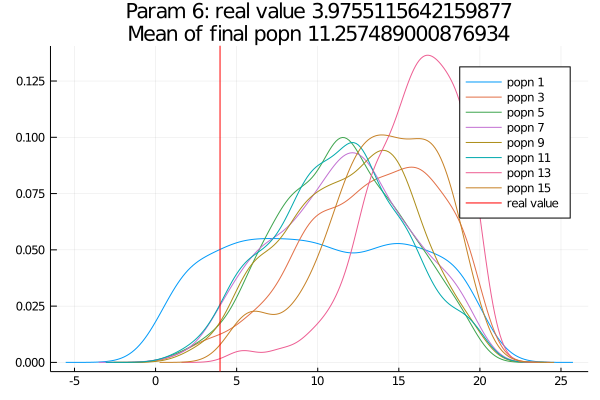

In [75]:
x = 6 #parameter number
real_param1 = params_lm[x]
curr_est_param = est_param[x]
y = 1 #population number
density(sim_abc_res.population[y][:,x],label = "popn $y",title = "Param $x: real value $real_param1
Mean of final popn $curr_est_param")
y = 3
density!(sim_abc_res.population[y][:,x],label = "popn $y")
y = 5
density!(sim_abc_res.population[y][:,x],label = "popn $y")
y = 7
density!(sim_abc_res.population[y][:,x],label = "popn $y")
y = 9
density!(sim_abc_res.population[y][:,x],label = "popn $y")
y = 11
density!(sim_abc_res.population[y][:,x],label = "popn $y")
y = 13
density!(sim_abc_res.population[y][:,x],label = "popn $y")
y = 15
density!(sim_abc_res.population[y][:,x],label = "popn $y")
vline!([real_param1], c = "red", label = "real value")

In [93]:
# date=Dates.today()
writedlm("results/20_05_05_ABC_SMC_distances.txt", sim_abc_res.distances, ",")
writedlm("results/20_05_05_ABC_SMC_accepted.txt", sim_abc_res.n_accepted, ",")
writedlm("results/20_05_05_ABC_SMC_tries.txt", sim_abc_res.n_tries, ",")
writedlm("results/20_05_05_ABC_SMC_thresholds.txt", sim_abc_res.threshold_schedule, ",")
writedlm("results/20_05_05_ABC_SMC_population.txt", sim_abc_res.population, ",")
writedlm("results/20_05_05_ABC_SMC_weights.txt", sim_abc_res.weights, ",")
writedlm("results/20_05_05_ABC_SMC_real_values.txt", params_lm, ",")


In [47]:
date=Dates.today()
#save results as comma delimited files with today's date
writedlm("results/20_05_05_ABC_SMC_final_popn1.txt", final_popns1, ",")
writedlm("results/20_05_05_ABC_SMC_final_popn2.txt", final_popns2, ",")
writedlm("results/20_05_05_ABC_SMC_final_popn3.txt", final_popns3, ",")
writedlm("results/20_04_05_ABC_SMC_difference_vect_3_params.txt", difference_vect, ",")
writedlm("results/20_04_15_ABC_SMC_real_params1.txt", real_param_vect1, ",")
writedlm("results/20_04_15_ABC_SMC_real_params2.txt", real_param_vect2, ",")
writedlm("results/20_04_15_ABC_SMC_real_params3.txt", real_param_vect3, ",")

2020-04-16

In [7]:
final_popns1= Array(CSV.read("results/20_04_15_ABC_SMC_final_popn1.txt" ))
final_popns2= Array(CSV.read("results/20_04_15_ABC_SMC_final_popn2.txt" ))
final_popns3= Array(CSV.read("results/20_04_15_ABC_SMC_final_popn3.txt" ))
difference_vect= Array(CSV.read("results/20_04_15_ABC_SMC_difference_vect_3_params.txt" ))
real_param_vect1= Array(CSV.read("results/20_04_15_ABC_SMC_real_params1.txt" ))
real_param_vect2=Array(CSV.read("results/20_04_15_ABC_SMC_real_params2.txt" ));
real_param_vect3=Array(CSV.read("results/20_04_15_ABC_SMC_real_params3.txt" ));

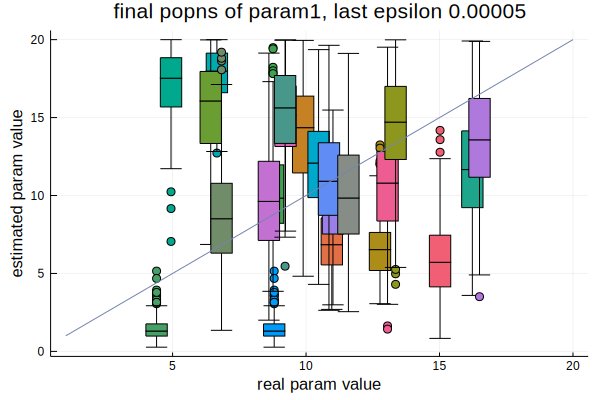

In [39]:
boxplot(real_param_vect1', final_popns1',title = "final popns of param1, last epsilon 0.00005", xlab = "real param value", ylab = "estimated param value", label = "")
plot!(1:20, label = "")

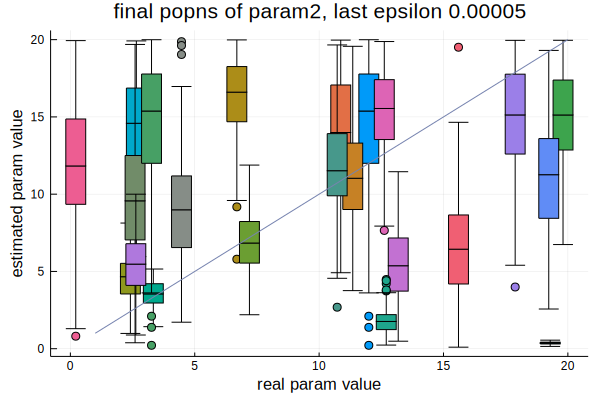

In [40]:
boxplot(real_param_vect2', final_popns2',title = "final popns of param2, last epsilon 0.00005", xlab = "real param value", ylab = "estimated param value", label = "")
plot!(1:20, label = "")

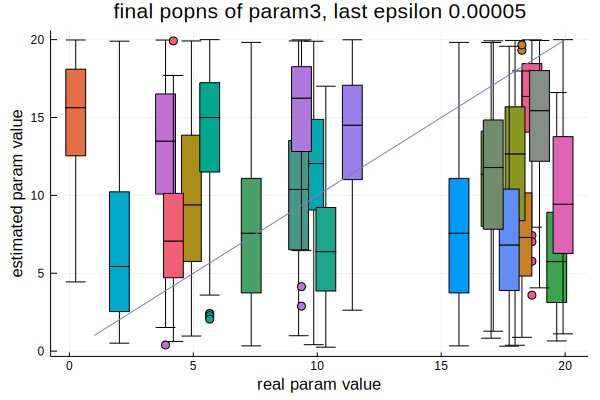

In [41]:
boxplot(real_param_vect3', final_popns3',title = "final popns of param3, last epsilon 0.00005", xlab = "real param value", ylab = "estimated param value", label = "")
plot!(1:20, label = "")

In [21]:
# @parameters t

# @variables s_out(t) rmr(t) em(t) rmq(t) rmt(t) et(t) rmm(t) mt(t) mm(t) q(t) si(t) mq(t) mr(t) r(t) NH4(t) nit_mrna(t) nit_mrna_ribo(t) nit(t) NH4_ex(t) N(t) a(t) AA(t) AA_prot(t) AA_mrna(t) AA_mrna_ribo(t)

# #############check the last parameter k_ribo_a
# ###############

# @parameters k_cat_AA k_a_NH4 k_NH4 k_a_AA k_NH4_AA k_a #these are the parameters to be varied in ABC
# gam= (gmax*a*AA)/(k_ribo_a*k_ribo_a_AA+k_ribo_a_AA*a+k_ribo_AA_a*AA+a*AA) #updated gamma equation that uses both ATP and AA
# ttrate= (rmq + rmr + rmt + rmm + nit_mrna_ribo+AA_mrna_ribo)*gam #total translation rate (sum of the mRNA/ribosome complexes times translation rate)
# lam= ttrate/M #lambda is the growth rate
# nucat= em*vm*si/(Km + abs(si))
# AA_vo = ((k_cat_AA*2*a*NH4)/(k_a_NH4*k_a))/(1+(1+(AA/k_a_AA))+(NH4/k_a_NH4)+(1+(AA/k_NH4_AA))+(NH4/k_NH4))
# new_AA = AA_vo*AA_prot
# AA_a_use = new_AA*2 #each AA produced uses x number of ATP molecules
# AA_NH4_use = new_AA*2 #each AA produced uses 2 NH4 molecules
# export_rate = 0 #export rate of NH4
# fixation = 0
# death_rate = 0
# k_ribo_a_AA = 10000.0
# k_ribo_AA_a = 10000.0
# k_ribo_a = 10.0

# @derivatives D'~t

# eqs = [
#     D(s_out)~ 0 #((-et*vt*s_out/(Kt+s_out))*N)-ds*s_out+(export_rate*NH4*50)+1e7
#     D(rmr)~ kb*r*mr-ku*rmr-(gam/nr)*rmr-lam*rmr
#     D(em)~ (gam/nx)*rmm-lam*em
#     D(rmq)~ kb*r*mq-ku*rmq-(gam/nx)*rmq-lam*rmq
#     D(rmt)~ kb*r*mt-ku*rmt-gam/nx*rmt-lam*rmt
#     D(et)~ (gam/nx)*rmt-lam*et
#     D(rmm)~ kb*r*mm-ku*rmm-gam/nx*rmm-lam*rmm
#     D(mt)~ (we*a/(thetax+a))+ku*rmt+(gam/nx)*rmt-kb*r*mt-dm*mt-lam*mt
#     D(mm)~ (we*a/(thetax+a))+ku*rmm+(gam/nx)*rmm-kb*r*mm-dm*mm-lam*mm
#     D(q)~ (gam/nx)*rmq-lam*q
#     D(si)~ (et*vt*s_out/(Kt+s_out))-nucat-lam*si
#     D(mq)~ (wq*a/(thetax+a)/(1+(q/Kq)^nq))+ku*rmq+(gam/nx)*rmq-kb*r*mq-dm*mq-lam*mq
#     D(mr)~ (wr*a/(thetar+a))+ku*rmr+(gam/nr)*rmr-kb*r*mr-dm*mr-lam*mr
#     D(r)~ ku*rmr+ku*rmt+ku*rmm+ku*rmq+(gam/nr)*rmr+(gam/nr)*rmr+(gam/nx)*rmt+(gam/nx)*rmm+(gam/nx)*rmq-kb*r*mr-kb*r*mt-kb*r*mm-kb*r*mq+ku*nit_mrna_ribo+(gam/nx)*nit_mrna_ribo-kb*r*nit_mrna+ku*AA_mrna_ribo+(gam/nx)*AA_mrna_ribo-kb*r*AA_mrna-lam*r
#     D(NH4)~ 0 #fixation*nit-export_rate*NH4-lam*NH4-AA_NH4_use+2.3e6
#     D(nit_mrna)~ 0 #(v_nit*a/(thetax + a))+(ku*nit_mrna_ribo)+(gam/nx*nit_mrna_ribo)-(kb*r*nit_mrna)-(dm*nit_mrna)-(lam*nit_mrna) #num of free nitrogenase coding mRNA
#     D(nit_mrna_ribo)~ 0 #(kb*r*nit_mrna)-(ku*nit_mrna_ribo)-(gam/nx*nit_mrna_ribo)-(lam*nit_mrna_ribo) #num of nit mRNA-ribosome complexes
#     D(nit)~ 0 #(gam/nx)*nit_mrna_ribo-lam*nit #num of nitrogenase proteins
#     D(NH4_ex)~ 0 #(export_rate*NH4)#total num of NH4 molecules exported this timestep
#     D(N)~ 0 #lam*N-death_rate*N #the change in num of bacterial cells instead of just loss to dilution
#     D(a)~ ns*nucat-ttrate-fixation*nit-AA_a_use-lam*a
#     D(AA)~ new_AA-ttrate-lam*AA
#     D(AA_prot)~ (gam/nx)*AA_mrna_ribo-lam*AA_prot
#     D(AA_mrna)~ ((w_AA*a/(thetax+a)))+(ku*AA_mrna_ribo)+(gam/nx*AA_mrna_ribo)-(kb*r*AA_mrna)-(dm*AA_mrna)-(lam*AA_mrna)
#     D(AA_mrna_ribo)~ (kb*r*AA_mrna)-(ku*AA_mrna_ribo)-(gam/nx*AA_mrna_ribo)-(lam*AA_mrna_ribo)
# ];

# println("System defined successfully")

# de = ODESystem(eqs, t, [s_out, rmr, em, rmq, rmt, 
#         et, rmm, mt, mm, q, si, mq, mr, r, NH4, nit_mrna,
#         nit_mrna_ribo, nit, NH4_ex, N, a, AA, AA_prot,
#         AA_mrna, AA_mrna_ribo],[k_cat_AA,k_a_NH4 ,k_NH4, k_a_AA, k_NH4_AA, k_a])

# f = ODEFunction(de)
# p = [10.0,10.0,10.0,10.0,10.0,10.0]

System defined successfully


In [32]:
# param1_run1=final_popns1[1,:]
# param1_run2=final_popns1[2,:]
# param1_run3=final_popns1[3,:]
# param1_run4=final_popns1[4,:]
# param1_run5=final_popns1[5,:]
# param1_run6=final_popns1[6,:]
# param1_run7=final_popns1[7,:]
# param1_run8=final_popns1[8,:]
# param1_run9=final_popns1[9,:];


# vals = []
# for i in range(1,stop = 10)
#     push!(vals,repeat([real_param_vect1[i]],outer = 300))
# end
# vals = collect(Iterators.flatten(vals))

# # flatfinpops = collect(Iterators.flatten(final_popns1))
# flatfinpops = collect(Iterators.flatten(Array([param1_run1,param1_run2,param1_run3,param1_run4,param1_run5,param1_run6,param1_run7,param1_run8,param1_run9,final_popns1[10,:]])))

# boxplot(vals,flatfinpops, label="", title = "final popns of param1, last epsilon 0.00005", xlab = "real param value", ylab = "estimated param value", size = (700,500))
# plot!([1:20], label = "")